In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os
import sys
import random

# Add the current directory to Python path for imports
sys.path.append('.')

# Import our infrastructure
from student.zoo import create_resnet110_cifar10, create_densenet121_cifar10, create_vgg_cifar10, build_student
from explainers.gradcam import GradCAM
from explainers.gradcam_utils import set_inplace
from data.indexed_dataset import CIFAR10WithIndex

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Configure matplotlib
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 10

Using device: cuda


In [5]:
def load_model(model_path, model_type):
    """Load a model from checkpoint with proper architecture"""
    if model_type == 'resnet110':
        model = create_resnet110_cifar10()
    elif model_type == 'densenet':
        model = create_densenet121_cifar10()
    elif model_type == 'vgg19':
        model = create_vgg_cifar10('vgg19')
    elif model_type == 'student':
        model = build_student(num_classes=10)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict):
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        elif 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            # Assume it's just the state dict
            model.load_state_dict(checkpoint)
    else:
        model.load_state_dict(checkpoint)
    
    model.to(device)
    model.eval()
    return model

def get_8x8_target_layer(model, model_type):
    """Get the layer that produces 8x8 feature maps for each model type"""
    if model_type == 'resnet110':
        # After layer2, before layer3 - should be 8x8
        return model.layer2[-1]
    elif model_type == 'student':
        # ResNet20 - after layer2
        return model.layer2[-1]  
    elif model_type == 'densenet':
        # DenseNet - transition2 should give 8x8
        return model.features.transition2
    elif model_type == 'vgg19':
        # VGG19 - around conv layer that gives 8x8 (after several downsamples)
        return model.features[34]  # Approximate layer for 8x8 output
    else:
        raise ValueError(f"Unknown model type: {model_type}")

def denormalize_image(tensor):
    """Denormalize CIFAR-10 image for visualization"""
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).reshape(3, 1, 1)
    
    # Denormalize
    tensor = tensor * std + mean
    # Clamp to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)
    
    return tensor

In [6]:
print("Loading models...")

# Load all models
resnet110 = load_model('teachers/best_models/resnet110_best.pth', 'resnet110')
densenet = load_model('teachers/best_models/densenet121_best.pth', 'densenet')
vgg19 = load_model('teachers/best_models/vgg19_best.pth', 'vgg19')
student = load_model('results/run_b_augmented_recipe_20250610_021456/best_model_90.22pct.pth', 'student')

# Fix VGG19 inplace operations
set_inplace(vgg19, False)

print("Models loaded successfully!")

# Load test dataset
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Fix the path - torchvision expects the parent directory containing cifar-10-batches-py
test_dataset = CIFAR10WithIndex(root='./', train=False, 
                               transform=test_transform, download=False)

print(f"Test dataset size: {len(test_dataset)}")

Loading models...
Models loaded successfully!
Test dataset size: 10000


In [7]:
# Get a random test image
random_idx = random.randint(0, len(test_dataset) - 1)
image, true_label, dataset_idx = test_dataset[random_idx]

print(f"Selected image {dataset_idx}, true class: {class_names[true_label]}")

# Prepare models and target layers for 8x8 Grad-CAM
models_info = {
    'ResNet110': {'model': resnet110, 'type': 'resnet110'},
    'DenseNet121': {'model': densenet, 'type': 'densenet'},
    'VGG19': {'model': vgg19, 'type': 'vgg19'},
    'Student': {'model': student, 'type': 'student'}
}

# Generate Grad-CAMs
gradcams = {}
predictions = {}

for name, info in models_info.items():
    print(f"Generating Grad-CAM for {name}...")
    
    model = info['model']
    model_type = info['type']
    
    # Get target layer for 8x8 output
    target_layer = get_8x8_target_layer(model, model_type)
    print(f"  Target layer: {target_layer}")
    
    # Create GradCAM instance
    gradcam = GradCAM(model, target_layer)
    
    # Get prediction
    with torch.no_grad():
        image_batch = image.unsqueeze(0).to(device)
        logits = model(image_batch)
        probs = F.softmax(logits, dim=1)
        pred_class = logits.argmax(dim=1).item()
        confidence = probs[0, pred_class].item()
    
    predictions[name] = {
        'class': pred_class,
        'confidence': confidence,
        'class_name': class_names[pred_class]
    }
    
    # Generate Grad-CAM for predicted class
    cam = gradcam(image_batch, pred_class)
    print(f"  CAM shape: {cam.shape}")
    
    # Upsample to 32x32 for visualization
    cam_upsampled = F.interpolate(cam, size=(32, 32), mode='bilinear', align_corners=False)
    gradcams[name] = cam_upsampled.squeeze().cpu().numpy()

print("Grad-CAM generation complete!")

Selected image 1824, true class: truck
Generating Grad-CAM for ResNet110...
  Target layer: BasicBlock(
  (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)
  CAM shape: torch.Size([1, 1, 16, 16])
Generating Grad-CAM for DenseNet121...
  Target layer: _Transition(
  (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
  CAM shape: torch.Size([1, 1, 8, 8])
Generating Grad-CAM for VGG19...
  Target layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

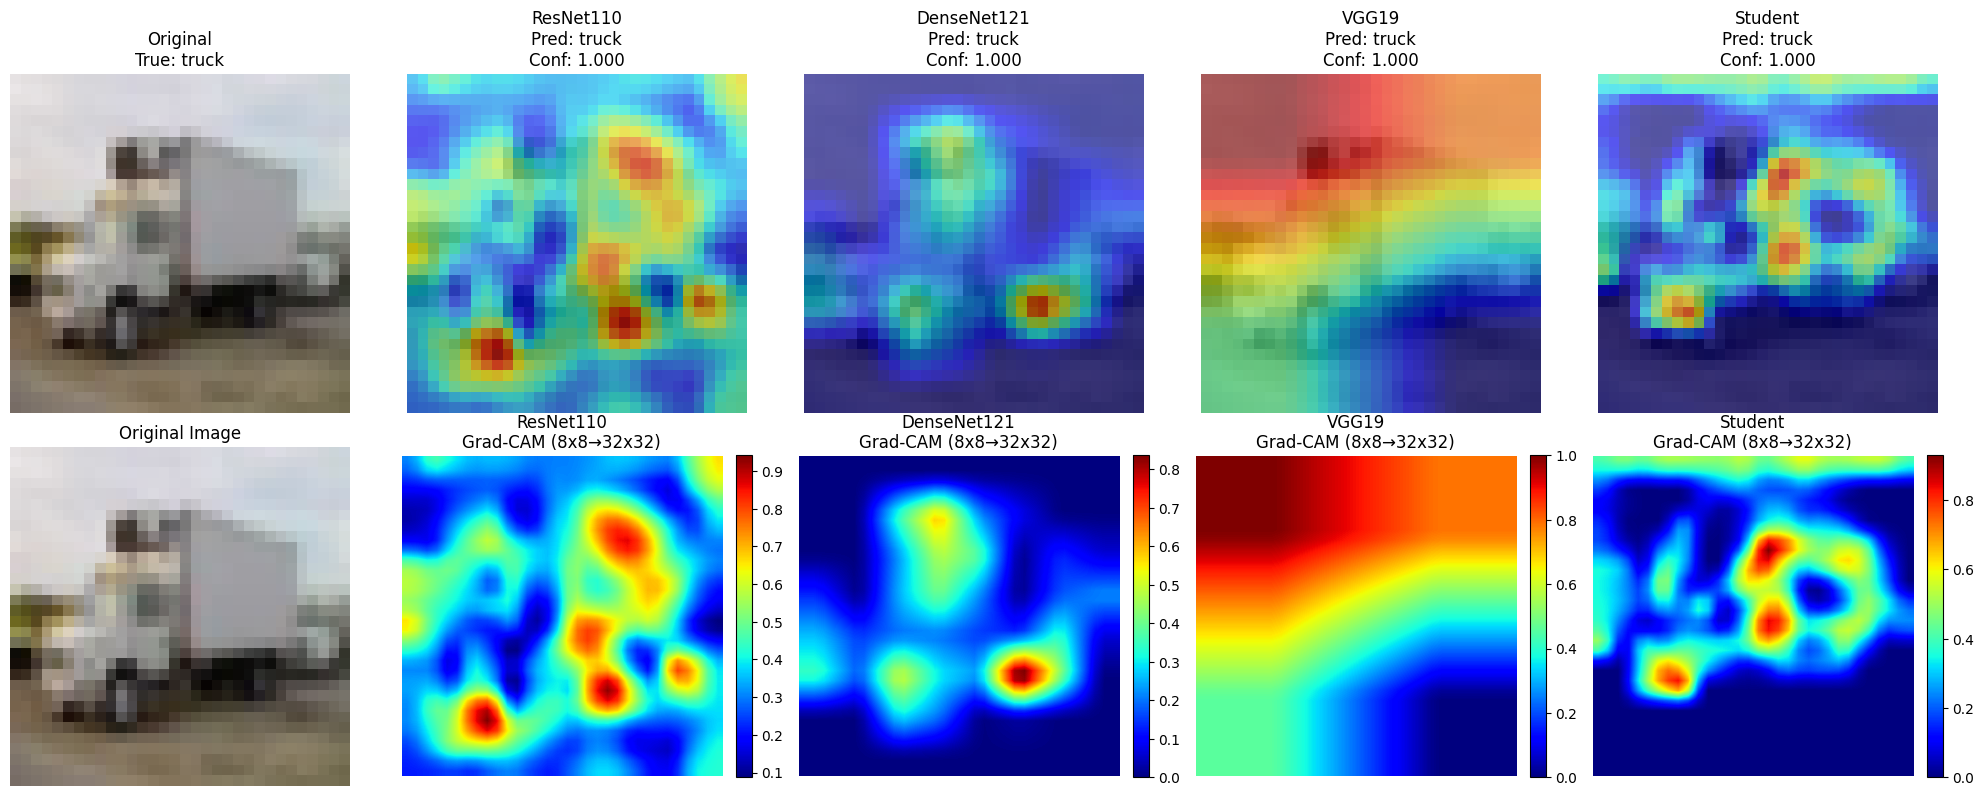


PREDICTION SUMMARY
True Label: truck
------------------------------------------------------------
ResNet110    | truck        | 1.000 | ✓
DenseNet121  | truck        | 1.000 | ✓
VGG19        | truck        | 1.000 | ✓
Student      | truck        | 1.000 | ✓


In [8]:
# Create visualization
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Denormalize original image for display
display_image = denormalize_image(image).permute(1, 2, 0).numpy()

# Row 1: Original image + Grad-CAM overlays
axes[0, 0].imshow(display_image)
axes[0, 0].set_title(f'Original\nTrue: {class_names[true_label]}')
axes[0, 0].axis('off')

for i, (name, cam) in enumerate(gradcams.items(), 1):
    # Create overlay
    overlay = display_image.copy()
    heatmap = plt.cm.jet(cam)[:, :, :3]  # Remove alpha channel
    overlayed = 0.6 * heatmap + 0.4 * overlay
    
    axes[0, i].imshow(overlayed)
    pred_info = predictions[name]
    axes[0, i].set_title(f'{name}\nPred: {pred_info["class_name"]}\nConf: {pred_info["confidence"]:.3f}')
    axes[0, i].axis('off')

# Row 2: Pure heatmaps
axes[1, 0].imshow(display_image)
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')

for i, (name, cam) in enumerate(gradcams.items(), 1):
    im = axes[1, i].imshow(cam, cmap='jet', interpolation='bilinear')
    axes[1, i].set_title(f'{name}\nGrad-CAM (8x8→32x32)')
    axes[1, i].axis('off')
    plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("PREDICTION SUMMARY")
print("="*60)
print(f"True Label: {class_names[true_label]}")
print("-"*60)
for name, pred_info in predictions.items():
    correct = "✓" if pred_info['class'] == true_label else "✗"
    print(f"{name:12} | {pred_info['class_name']:12} | {pred_info['confidence']:.3f} | {correct}")

In [9]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_model(model, test_loader, device):
    """Evaluate a model on the test set and return accuracy"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Create test loader for evaluation (larger batch size for efficiency)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

print("Evaluating all models on CIFAR-10 test set...")
print("=" * 60)

# Dictionary to store results
model_accuracies = {}

# Evaluate each model
models_to_evaluate = {
    'ResNet110': resnet110,
    'DenseNet121': densenet,
    'VGG19': vgg19,
    'Student (90.22%)': student
}

for model_name, model in models_to_evaluate.items():
    print(f"\nEvaluating {model_name}...")
    accuracy = evaluate_model(model, test_loader, device)
    model_accuracies[model_name] = accuracy
    print(f"{model_name} Test Accuracy: {accuracy:.2f}%")

print("\n" + "=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)

# Display results
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name:20}: {accuracy:.2f}%")

Evaluating all models on CIFAR-10 test set...

Evaluating ResNet110...


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.42it/s]


ResNet110 Test Accuracy: 93.85%

Evaluating DenseNet121...


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.13it/s]


DenseNet121 Test Accuracy: 95.54%

Evaluating VGG19...


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 18.32it/s]


VGG19 Test Accuracy: 91.14%

Evaluating Student (90.22%)...


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 27.46it/s]

Student (90.22%) Test Accuracy: 90.22%

EVALUATION COMPLETE
ResNet110           : 93.85%
DenseNet121         : 95.54%
VGG19               : 91.14%
Student (90.22%)    : 90.22%


/var/tmp/ipykernel_1557037/1264532291.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


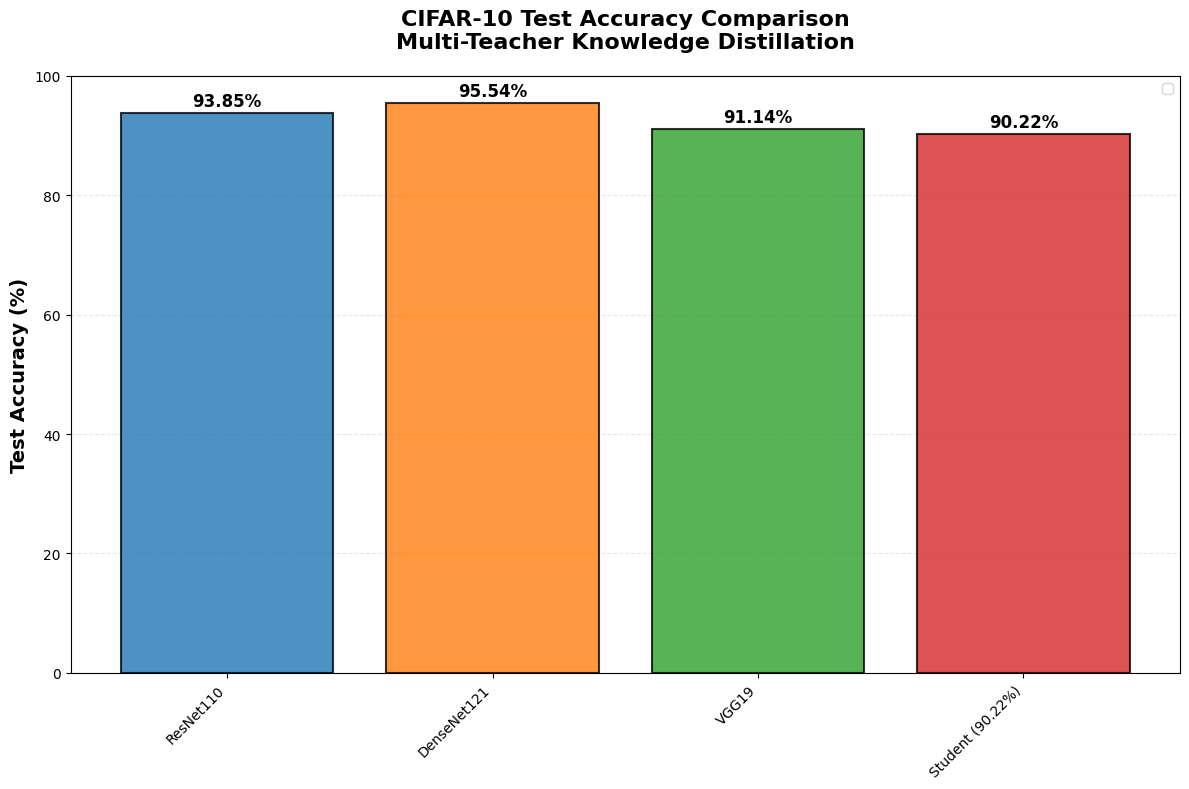

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Create color scheme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(model_names, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Customize the chart
ax.set_ylabel('Test Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('CIFAR-10 Test Accuracy Comparison\nMulti-Teacher Knowledge Distillation', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, 100)

# Add value labels on top of bars
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{accuracy:.2f}%', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend(loc='upper right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def get_predictions(model, test_loader, device):
    """Get all predictions and true labels from the test set"""
    model.eval()
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for images, labels, _ in tqdm(test_loader, desc="Getting predictions"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    
    return np.array(all_true_labels), np.array(all_predictions)

# Get predictions for the student model
print("Collecting predictions from student model...")
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

true_labels, predictions = get_predictions(student, test_loader, device)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

print(f"Collected {len(true_labels)} predictions")
print(f"Student model accuracy: {(predictions == true_labels).mean() * 100:.2f}%")

Getting predictions: 100%|██████████| 40/40 [00:01<00:00, 24.70it/s]

Collected 10000 predictions
Student model accuracy: 90.22%


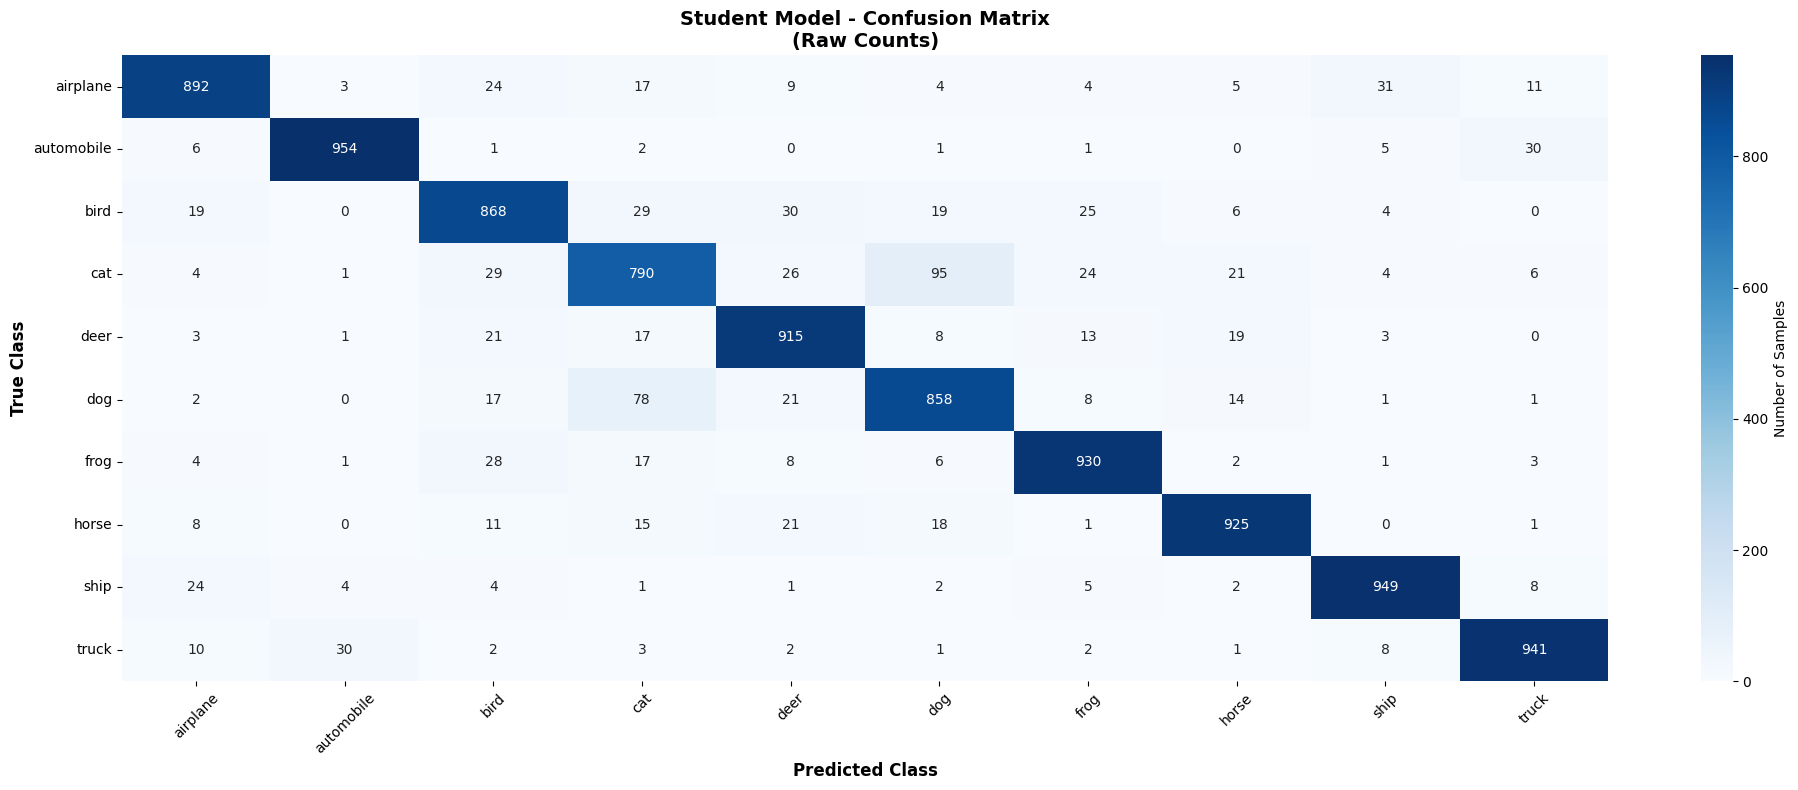


CLASS-WISE ACCURACY ANALYSIS
airplane    :  89.2% ( 892/1000)
automobile  :  95.4% ( 954/1000)
bird        :  86.8% ( 868/1000)
cat         :  79.0% ( 790/1000)
deer        :  91.5% ( 915/1000)
dog         :  85.8% ( 858/1000)
frog        :  93.0% ( 930/1000)
horse       :  92.5% ( 925/1000)
ship        :  94.9% ( 949/1000)
truck       :  94.1% ( 941/1000)


In [16]:
# Create confusion matrix visualization
fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))

# Plot 1: Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=ax1, cbar_kws={'label': 'Number of Samples'})
ax1.set_title('Student Model - Confusion Matrix\n(Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Class', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Calculate class-wise accuracies
class_accuracies = cm.diagonal() / cm.sum(axis=1) * 100

print("\n" + "="*60)
print("CLASS-WISE ACCURACY ANALYSIS")
print("="*60)
for i, (class_name, accuracy) in enumerate(zip(class_names, class_accuracies)):
    print(f"{class_name:12}: {accuracy:5.1f}% ({cm[i,i]:4d}/{cm[i].sum():4d})")

In [26]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

class CIFAR10CDataset(Dataset):
    """Dataset class for CIFAR-10-C corrupted images with severity selection"""
    
    def __init__(self, corruption_type, severity_level=5, transform=None):
        self.corruption_type = corruption_type
        self.severity_level = severity_level
        self.transform = transform
        
        # Load corrupted images and labels
        data_path = f'./data/CIFAR-10-C/{corruption_type}.npy'
        labels_path = './data/CIFAR-10-C/labels.npy'
        
        # Load data
        all_images = np.load(data_path)
        all_labels = np.load(labels_path)
        
        # CIFAR-10-C has 5 severity levels, each with 10,000 images
        start_idx = (severity_level - 1) * 10000
        end_idx = severity_level * 10000
        
        self.images = all_images[start_idx:end_idx]
        self.labels = all_labels[start_idx:end_idx]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL Image and apply transforms
        from PIL import Image
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def evaluate_model_on_corruption_severity(model, corruption_type, severity_level, device, batch_size=256):
    """Evaluate a model on a specific corruption type and severity level"""
    
    # Create transform (same as training)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Create dataset and loader
    dataset = CIFAR10CDataset(corruption_type, severity_level, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Evaluate
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# List all corruption types
corruption_types = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate', 
    'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate'
]

# Model mapping
models_dict = {
    'ResNet110': resnet110,
    'DenseNet121': densenet,
    'VGG19': vgg19,
    'Student': student
}

print("Starting comprehensive CIFAR-10-C evaluation across ALL severities...")
print("=" * 80)
print(f"Evaluating {len(models_dict)} models on {len(corruption_types)} corruptions × 5 severities")
print(f"Total evaluations: {len(models_dict) * len(corruption_types) * 5}")
print("=" * 80)

# Initialize comprehensive results storage
all_results = []

# Progress tracking
total_evaluations = len(models_dict) * len(corruption_types) * 5
current_eval = 0

# Evaluate each model on each corruption at each severity
for model_name, model in models_dict.items():
    print(f"\n{'='*20} EVALUATING {model_name.upper()} {'='*20}")
    
    for corruption_type in corruption_types:
        print(f"\nCorruption: {corruption_type}")
        severity_results = []
        
        for severity in range(1, 6):  # Severities 1-5
            current_eval += 1
            try:
                accuracy = evaluate_model_on_corruption_severity(
                    model, corruption_type, severity, device
                )
                severity_results.append(accuracy)
                
                # Store detailed result
                all_results.append({
                    'Model': model_name,
                    'Corruption': corruption_type,
                    'Severity': severity,
                    'Accuracy': accuracy
                })
                
                print(f"  Severity {severity}: {accuracy:5.2f}% "
                      f"[{current_eval}/{total_evaluations}]")
                
            except Exception as e:
                print(f"  Error at severity {severity}: {e}")
                all_results.append({
                    'Model': model_name,
                    'Corruption': corruption_type,
                    'Severity': severity,
                    'Accuracy': 0.0
                })
        
        # Print average for this corruption across severities
        if severity_results:
            avg_accuracy = np.mean(severity_results)
            print(f"  → Average across severities: {avg_accuracy:5.2f}%")

print("\n" + "=" * 80)
print("COMPREHENSIVE EVALUATION COMPLETE!")
print("=" * 80)

Starting comprehensive CIFAR-10-C evaluation across ALL severities...
Evaluating 4 models on 19 corruptions × 5 severities
Total evaluations: 380

==================== EVALUATING RESNET110 ====================

Corruption: gaussian_noise


  Severity 1: 77.75% [1/380]
  Severity 2: 55.66% [2/380]
  Severity 3: 35.81% [3/380]
  Severity 4: 28.56% [4/380]
  Severity 5: 24.17% [5/380]
  → Average across severities: 44.39%

Corruption: shot_noise
  Severity 1: 85.62% [6/380]
  Severity 2: 75.43% [7/380]
  Severity 3: 50.09% [8/380]
  Severity 4: 41.12% [9/380]
  Severity 5: 30.00% [10/380]
  → Average across severities: 56.45%

Corruption: impulse_noise
  Severity 1: 84.45% [11/380]
  Severity 2: 73.87% [12/380]
  Severity 3: 62.96% [13/380]
  Severity 4: 40.33% [14/380]
  Severity 5: 24.31% [15/380]
  → Average across severities: 57.18%

Corruption: defocus_blur
  Severity 1: 93.51% [16/380]
  Severity 2: 92.25% [17/380]
  Severity 3: 87.70% [18/380]
  Severity 4: 80.15% [19/380]
  Severity 5: 62.65% [20/380]
  → Average across severities: 83.25%

Corruption: glass_blur
  Severity 1: 44.54% [21/380]
  Severity 2: 47.28% [22/380]
  Severity 3: 52.10% [23/380]
  Severity 4: 36.31% [24/380]
  Severity 5: 40.54% [25/380]
  → Av

In [29]:
# Create DataFrame from all results
df_all = pd.DataFrame(all_results)

print("COMPREHENSIVE CIFAR-10-C ROBUSTNESS RESULTS")
print("=" * 80)

# 1. Create table with averages across severities for each corruption
print("\n1. AVERAGE ACCURACY PER CORRUPTION (across all 5 severities)")
print("-" * 80)

# Calculate average across severities for each model-corruption pair
corruption_averages = df_all.groupby(['Model', 'Corruption'])['Accuracy'].mean().unstack()

# Format and display
corruption_averages_formatted = corruption_averages.round(2)
print(corruption_averages_formatted.to_string())

# Calculate overall averages correctly (mean across columns for each model)
print(f"\nOVERALL AVERAGES (across all corruptions and severities):")
print("-" * 60)

model_overall_averages = corruption_averages.mean(axis=1)  # Mean across columns (corruptions)

for model in model_overall_averages.index:
    overall_avg = model_overall_averages[model]
    print(f"{model:15}: {overall_avg:5.2f}%")

# 2. Create severity-wise breakdown table
print(f"\n\n2. DETAILED BREAKDOWN BY SEVERITY LEVELS")
print("-" * 80)

# Calculate average across corruptions for each model-severity pair
severity_averages = df_all.groupby(['Model', 'Severity'])['Accuracy'].mean().unstack()

print("Average accuracy per severity level (across all 19 corruptions):")
print(severity_averages.round(2).to_string())

# 3. Model ranking analysis
print(f"\n\n3. ROBUSTNESS RANKING")
print("-" * 80)

model_overall_scores = model_overall_averages.sort_values(ascending=False)

print("Final robustness ranking (higher = more robust):")
for rank, (model, score) in enumerate(model_overall_scores.items(), 1):
    print(f"{rank}. {model:15}: {score:5.2f}%")

# 4. Add summary table with all key metrics
print(f"\n\n4. COMPREHENSIVE SUMMARY TABLE")
print("-" * 80)

# Create a comprehensive summary
summary_data = []

for model in model_overall_averages.index:
    # Overall average
    overall_avg = model_overall_averages[model]
    
    # Best and worst corruptions
    model_corruption_scores = corruption_averages.loc[model]
    best_corruption = model_corruption_scores.idxmax()
    worst_corruption = model_corruption_scores.idxmin()
    best_score = model_corruption_scores.max()
    worst_score = model_corruption_scores.min()
    
    # Standard deviation (consistency)
    std_dev = model_corruption_scores.std()
    
    # Severity 1 vs Severity 5 performance
    sev1_avg = df_all[(df_all['Model'] == model) & (df_all['Severity'] == 1)]['Accuracy'].mean()
    sev5_avg = df_all[(df_all['Model'] == model) & (df_all['Severity'] == 5)]['Accuracy'].mean()
    severity_drop = sev1_avg - sev5_avg
    
    summary_data.append({
        'Model': model,
        'Overall_Avg': overall_avg,
        'Best_Corruption': best_corruption,
        'Best_Score': best_score,
        'Worst_Corruption': worst_corruption,
        'Worst_Score': worst_score,
        'Std_Dev': std_dev,
        'Severity_1_Avg': sev1_avg,
        'Severity_5_Avg': sev5_avg,
        'Severity_Drop': severity_drop
    })

summary_df = pd.DataFrame(summary_data)

print("Detailed model comparison:")
print("-" * 100)
print(f"{'Model':<12} | {'Overall':<7} | {'Best Corruption':<15} | {'Best':<5} | {'Worst Corruption':<16} | {'Worst':<5} | {'Std':<5} | {'Sev1':<5} | {'Sev5':<5} | {'Drop':<5}")
print("-" * 100)

for _, row in summary_df.iterrows():
    print(f"{row['Model']:<12} | {row['Overall_Avg']:5.2f}%  | {row['Best_Corruption']:<15} | {row['Best_Score']:5.1f} | {row['Worst_Corruption']:<16} | {row['Worst_Score']:5.1f} | {row['Std_Dev']:5.2f} | {row['Severity_1_Avg']:5.1f} | {row['Severity_5_Avg']:5.1f} | {row['Severity_Drop']:5.1f}")

# Save comprehensive results
df_all.to_csv('cifar10c_comprehensive_results.csv', index=False)
corruption_averages.to_csv('cifar10c_corruption_averages.csv')
severity_averages.to_csv('cifar10c_severity_averages.csv')
summary_df.to_csv('cifar10c_model_summary.csv', index=False)

print(f"\nDetailed results saved to:")
print(f"  - cifar10c_comprehensive_results.csv (all individual results)")
print(f"  - cifar10c_corruption_averages.csv (averages per corruption)")
print(f"  - cifar10c_severity_averages.csv (averages per severity)")
print(f"  - cifar10c_model_summary.csv (comprehensive model comparison)")

# 5. Key insights
print(f"\n\n5. KEY INSIGHTS")
print("-" * 80)

best_model = model_overall_scores.index[0]
worst_model = model_overall_scores.index[-1]
performance_gap = model_overall_scores.iloc[0] - model_overall_scores.iloc[-1]

print(f"🏆 Most Robust Model: {best_model} ({model_overall_scores.iloc[0]:.2f}%)")
print(f"📉 Least Robust Model: {worst_model} ({model_overall_scores.iloc[-1]:.2f}%)")
print(f"📊 Performance Gap: {performance_gap:.2f}%")

# Student specific analysis
if 'Student' in model_overall_averages.index:
    student_rank = list(model_overall_scores.index).index('Student') + 1
    student_score = model_overall_averages['Student']
    
    print(f"\n🎓 Student Model Analysis:")
    print(f"   Robustness Rank: {student_rank}/4")
    print(f"   Overall Score: {student_score:.2f}%")
    
    # Compare to teachers
    teacher_scores = [model_overall_averages[model] for model in ['ResNet110', 'DenseNet121', 'VGG19']]
    avg_teacher_score = np.mean(teacher_scores)
    student_vs_teachers = student_score - avg_teacher_score
    
    print(f"   vs Teacher Average: {student_vs_teachers:+.2f}%")
    
    for teacher in ['ResNet110', 'DenseNet121', 'VGG19']:
        if teacher in model_overall_averages.index:
            gap = student_score - model_overall_averages[teacher]
            print(f"   vs {teacher}: {gap:+.2f}%")

print(f"\n✅ Evaluation complete! Total evaluations: {len(df_all)}")

COMPREHENSIVE CIFAR-10-C ROBUSTNESS RESULTS

1. AVERAGE ACCURACY PER CORRUPTION (across all 5 severities)
--------------------------------------------------------------------------------
Corruption   brightness  contrast  defocus_blur  elastic_transform   fog  frost  gaussian_blur  gaussian_noise  glass_blur  impulse_noise  jpeg_compression  motion_blur  pixelate  saturate  shot_noise  snow  spatter  speckle_noise  zoom_blur
Model                                                                                                                                                                                                                                            
DenseNet121       94.21     81.10         84.35              85.38 88.27  78.93          74.42           45.86       54.43          59.23             81.33        79.42     76.48     92.97       59.14 83.67    87.09          63.84      78.04
ResNet110         92.18     77.10         83.25              83.29 87.01  73.28        

In [30]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os
import glob
from core.similarity import cosine_flat_clipped, pearson_correlation, pearson_correlation_clipped
from explainers.gradcam import GradCAM

def load_teacher_cache(teacher_name, num_samples=1000):
    """Load teacher Grad-CAM cache efficiently"""
    cache_dir = f'./data/gradcam_cache/test/{teacher_name}'
    
    # Get all cache files
    cache_files = sorted(glob.glob(os.path.join(cache_dir, '*.npz')))
    
    if not cache_files:
        print(f"No cache files found for {teacher_name}")
        return None, None, None
    
    # Limit samples for faster testing (remove for full evaluation)
    cache_files = cache_files[:num_samples]
    
    teacher_maps = []
    indices = []
    labels = []
    
    print(f"Loading {len(cache_files)} cached maps for {teacher_name}...")
    
    for file_path in tqdm(cache_files, desc=f"Loading {teacher_name}"):
        try:
            data = np.load(file_path)
            heatmap = data['heatmap']  # Shape: (1, 32, 32)
            index = data['index'].item()
            label = data['label'].item()
            
            teacher_maps.append(heatmap)
            indices.append(index)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    
    # Stack into tensors
    teacher_maps = np.stack(teacher_maps, axis=0)  # Shape: (N, 1, 32, 32)
    teacher_maps = torch.from_numpy(teacher_maps).float()
    
    return teacher_maps, indices, labels

def generate_student_gradcam_batch(model, indices, device, batch_size=32):
    """Generate student Grad-CAM maps for specific indices"""
    # Load test dataset
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    test_dataset = CIFAR10WithIndex(root='./', train=False, 
                                   transform=test_transform, download=False)
    
    # Get target layer for student (ResNet20)
    target_layer = model.layer2[-1]  # Should produce 8×8 maps
    gradcam = GradCAM(model, target_layer)
    
    student_maps = []
    
    print(f"Generating student Grad-CAM for {len(indices)} samples...")
    
    # Process in batches
    for i in tqdm(range(0, len(indices), batch_size), desc="Student Grad-CAM"):
        batch_indices = indices[i:i+batch_size]
        batch_images = []
        batch_labels = []
        
        # Load batch of images
        for idx in batch_indices:
            image, label, _ = test_dataset[idx]
            batch_images.append(image)
            batch_labels.append(label)
        
        # Stack and move to device
        batch_images = torch.stack(batch_images).to(device)
        
        # Generate predictions for Grad-CAM
        with torch.no_grad():
            outputs = model(batch_images)
            predicted_classes = outputs.argmax(dim=1)
        
        # Generate Grad-CAM for each image in batch
        for j, (img, pred_class) in enumerate(zip(batch_images, predicted_classes)):
            img_batch = img.unsqueeze(0)  # Add batch dimension
            
            try:
                # Generate Grad-CAM
                cam = gradcam(img_batch, pred_class.item())
                
                # Upsample to 32×32 to match teacher cache format
                cam_upsampled = F.interpolate(cam, size=(32, 32), 
                                            mode='bilinear', align_corners=False)
                
                student_maps.append(cam_upsampled.squeeze().cpu())
                
            except Exception as e:
                print(f"Error generating Grad-CAM for index {batch_indices[j]}: {e}")
                # Add zero map as fallback
                student_maps.append(torch.zeros(1, 32, 32))
    
    # Stack all maps
    student_maps = torch.stack(student_maps, dim=0)  # Shape: (N, 1, 32, 32)
    
    return student_maps

print("Setting up Grad-CAM similarity analysis...")

# Load teacher caches (start with smaller sample for testing)
NUM_SAMPLES = 1000  # Increase to 10000 for full evaluation

teacher_data = {}
teacher_names = ['resnet', 'densenet', 'vgg19']

for teacher_name in teacher_names:
    print(f"\nLoading {teacher_name} cache...")
    maps, indices, labels = load_teacher_cache(teacher_name, NUM_SAMPLES)
    
    if maps is not None:
        teacher_data[teacher_name] = {
            'maps': maps,
            'indices': indices,
            'labels': labels
        }
        print(f"Loaded {len(maps)} maps for {teacher_name}")

print(f"\nLoaded caches for {len(teacher_data)} teachers")

Setting up Grad-CAM similarity analysis...

Loading resnet cache...
Loading 1000 cached maps for resnet...


Loading resnet: 100%|██████████| 1000/1000 [00:00<00:00, 1843.93it/s]


Loaded 1000 maps for resnet

Loading densenet cache...
Loading 1000 cached maps for densenet...


Loading densenet: 100%|██████████| 1000/1000 [00:00<00:00, 1904.85it/s]


Loaded 1000 maps for densenet

Loading vgg19 cache...
Loading 1000 cached maps for vgg19...


Loading vgg19: 100%|██████████| 1000/1000 [00:00<00:00, 1957.30it/s]

Loaded 1000 maps for vgg19

Loaded caches for 3 teachers


In [31]:
# Use the first teacher's indices as reference (all should have same indices)
reference_teacher = list(teacher_data.keys())[0]
reference_indices = teacher_data[reference_teacher]['indices']

print(f"Generating student Grad-CAM for {len(reference_indices)} samples...")

# Generate student maps
student_maps = generate_student_gradcam_batch(student, reference_indices, device, batch_size=32)

print(f"Generated student maps shape: {student_maps.shape}")

# Compute similarities for each teacher
similarity_results = {}

for teacher_name, teacher_info in teacher_data.items():
    print(f"\nComputing similarities with {teacher_name}...")
    
    teacher_maps = teacher_info['maps']
    
    # Ensure same number of samples
    min_samples = min(len(student_maps), len(teacher_maps))
    student_subset = student_maps[:min_samples]
    teacher_subset = teacher_maps[:min_samples]
    
    print(f"Computing for {min_samples} samples")
    print(f"Student maps shape: {student_subset.shape}")
    print(f"Teacher maps shape: {teacher_subset.shape}")
    
    # Compute different similarity metrics
    similarities = {}
    
    # Cosine similarity (clipped)
    cos_sim = cosine_flat_clipped(student_subset, teacher_subset)
    similarities['cosine_clipped'] = cos_sim.numpy()
    
    # Pearson correlation
    pearson_sim = pearson_correlation(student_subset, teacher_subset)
    similarities['pearson'] = pearson_sim.numpy()
    
    # Pearson correlation (clipped)
    pearson_clipped_sim = pearson_correlation_clipped(student_subset, teacher_subset)
    similarities['pearson_clipped'] = pearson_clipped_sim.numpy()
    
    similarity_results[teacher_name] = {
        'similarities': similarities,
        'indices': teacher_info['indices'][:min_samples],
        'labels': teacher_info['labels'][:min_samples]
    }
    
    # Print summary statistics
    print(f"Results for {teacher_name}:")
    for metric_name, values in similarities.items():
        print(f"  {metric_name:15}: mean={values.mean():.4f}, std={values.std():.4f}, "
              f"min={values.min():.4f}, max={values.max():.4f}")

print("\nSimilarity computation complete!")

Generating student Grad-CAM for 1000 samples...
Generating student Grad-CAM for 1000 samples...


Student Grad-CAM: 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]

Generated student maps shape: torch.Size([1000, 32, 32])

Computing similarities with resnet...
Computing for 1000 samples
Student maps shape: torch.Size([1000, 32, 32])
Teacher maps shape: torch.Size([1000, 1, 32, 32])
Results for resnet:
  cosine_clipped : mean=0.5570, std=0.1990, min=0.0000, max=0.9200
  pearson        : mean=0.1365, std=0.2584, min=-0.7358, max=0.8264
  pearson_clipped: mean=0.1880, std=0.1881, min=0.0000, max=0.8264

Computing similarities with densenet...
Computing for 1000 samples
Student maps shape: torch.Size([1000, 32, 32])
Teacher maps shape: torch.Size([1000, 1, 32, 32])
Results for densenet:
  cosine_clipped : mean=0.4125, std=0.2134, min=0.0000, max=0.8528
  pearson        : mean=0.0165, std=0.1841, min=-0.4488, max=0.6588
  pearson_clipped: mean=0.0806, std=0.1225, min=0.0000, max=0.6588

Computing similarities with vgg19...
Computing for 1000 samples
Student maps shape: torch.Size([1000, 32, 32])
Teacher maps shape: torch.Size([1000, 1, 32, 32])
Results

STUDENT vs TEACHER GRAD-CAM SIMILARITY ANALYSIS

OVERALL SIMILARITY STATISTICS:
--------------------------------------------------

RESNET:
  Cosine_Clipped : 0.5570 ± 0.1991
  Pearson        : 0.1365 ± 0.2586
  Pearson_Clipped: 0.1880 ± 0.1882

DENSENET:
  Cosine_Clipped : 0.4125 ± 0.2135
  Pearson        : 0.0165 ± 0.1842
  Pearson_Clipped: 0.0806 ± 0.1226

VGG19:
  Cosine_Clipped : 0.5262 ± 0.1953
  Pearson        : 0.0016 ± 0.1894
  Pearson_Clipped: 0.0769 ± 0.1063


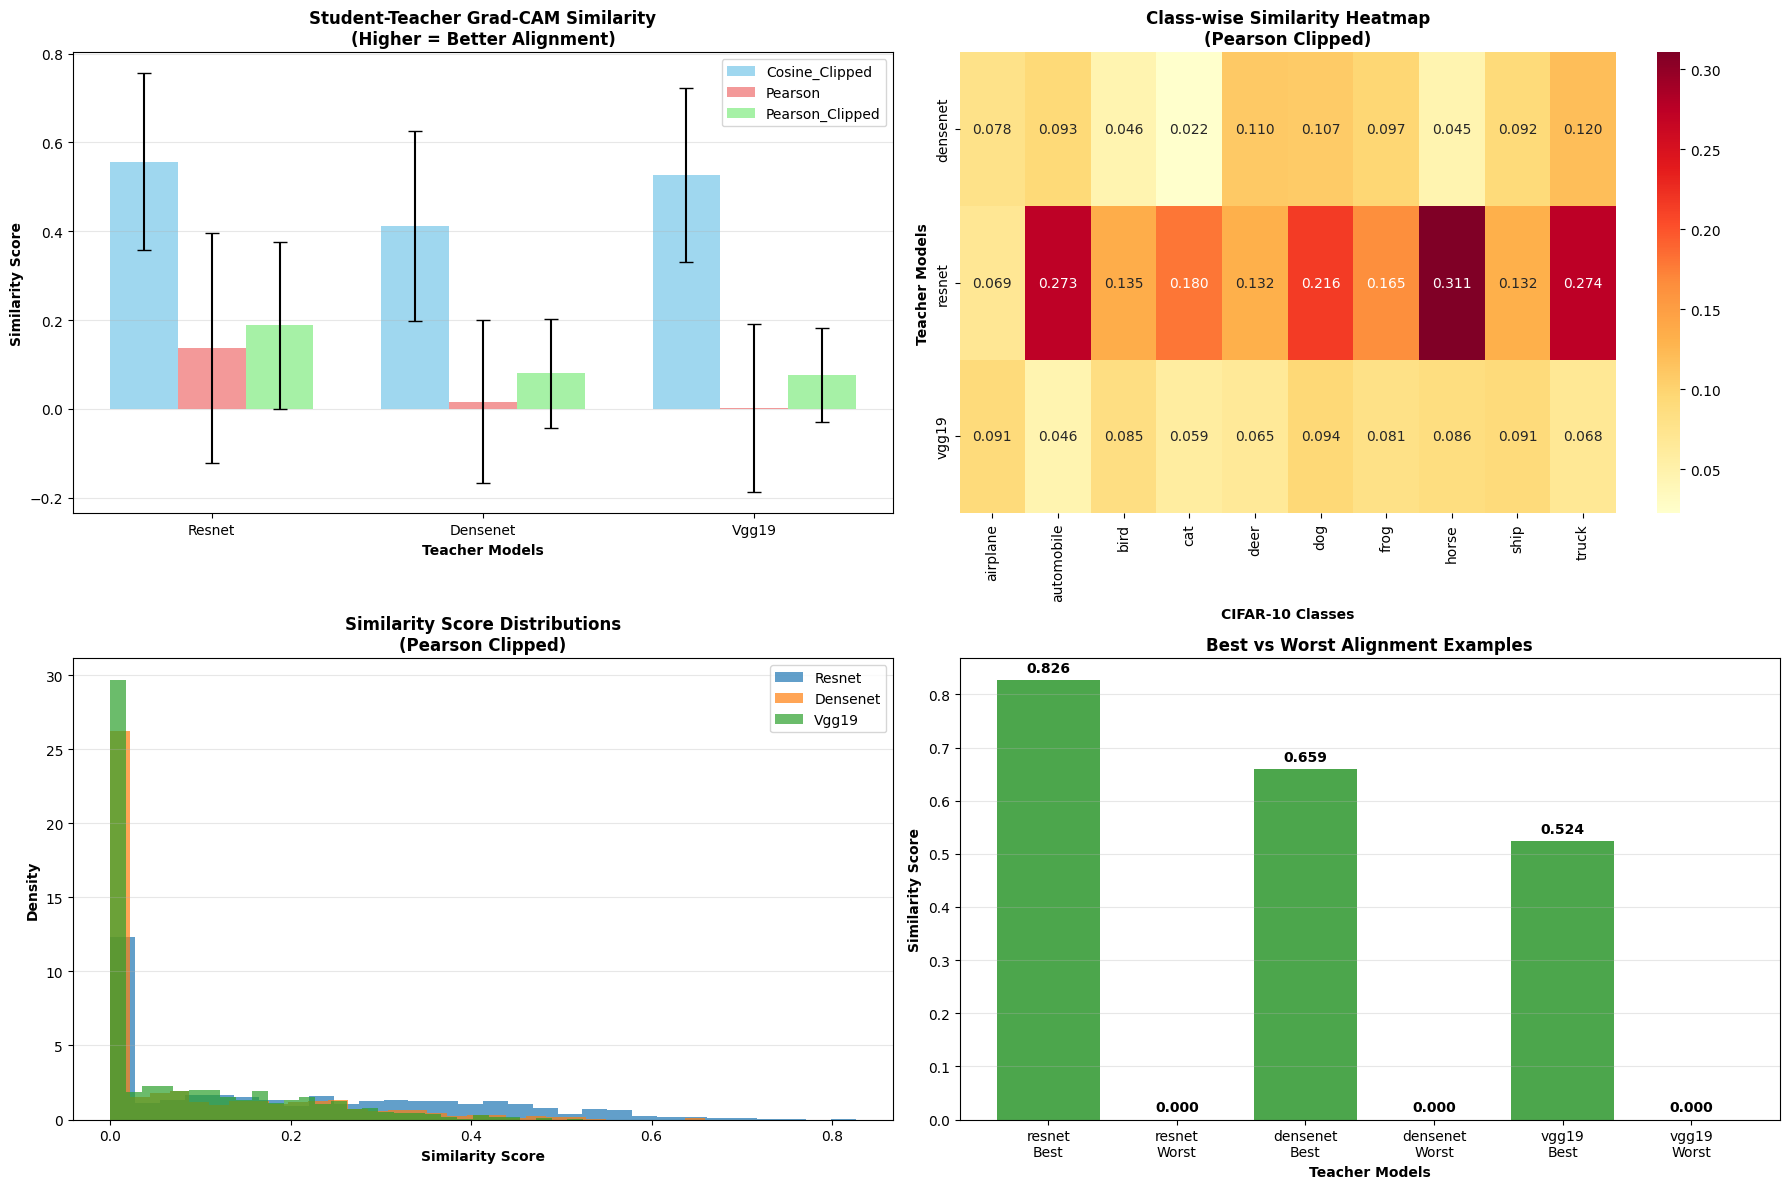


DETAILED ANALYSIS


IndexError: Column(s) Pearson_Clipped already selected

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create comprehensive results table
results_data = []

for teacher_name, results in similarity_results.items():
    similarities = results['similarities']
    labels = results['labels']
    
    for i, label in enumerate(labels):
        row = {
            'Teacher': teacher_name,
            'Sample_Index': results['indices'][i],
            'Class': class_names[label],
            'Class_ID': label,
            'Cosine_Clipped': similarities['cosine_clipped'][i],
            'Pearson': similarities['pearson'][i],
            'Pearson_Clipped': similarities['pearson_clipped'][i]
        }
        results_data.append(row)

# Create DataFrame
df_results = pd.DataFrame(results_data)

print("STUDENT vs TEACHER GRAD-CAM SIMILARITY ANALYSIS")
print("=" * 80)

# Overall statistics
print("\nOVERALL SIMILARITY STATISTICS:")
print("-" * 50)

summary_stats = df_results.groupby('Teacher')[['Cosine_Clipped', 'Pearson', 'Pearson_Clipped']].agg(['mean', 'std'])

for teacher in teacher_names:
    print(f"\n{teacher.upper()}:")
    teacher_data = summary_stats.loc[teacher]
    for metric in ['Cosine_Clipped', 'Pearson', 'Pearson_Clipped']:
        mean_val = teacher_data[metric]['mean']
        std_val = teacher_data[metric]['std']
        print(f"  {metric:15}: {mean_val:.4f} ± {std_val:.4f}")

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Overall similarity comparison
metrics = ['Cosine_Clipped', 'Pearson', 'Pearson_Clipped']
x = np.arange(len(teacher_names))
width = 0.25

colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics):
    means = [summary_stats.loc[teacher, metric]['mean'] for teacher in teacher_names]
    stds = [summary_stats.loc[teacher, metric]['std'] for teacher in teacher_names]
    
    ax1.bar(x + i*width, means, width, yerr=stds, label=metric, 
            color=colors[i], alpha=0.8, capsize=5)

ax1.set_xlabel('Teacher Models', fontweight='bold')
ax1.set_ylabel('Similarity Score', fontweight='bold')
ax1.set_title('Student-Teacher Grad-CAM Similarity\n(Higher = Better Alignment)', fontweight='bold')
ax1.set_xticks(x + width)
ax1.set_xticklabels([t.title() for t in teacher_names])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Similarity distribution heatmap
pivot_data = df_results.groupby(['Teacher', 'Class'])['Pearson_Clipped'].mean().unstack()

sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
ax2.set_title('Class-wise Similarity Heatmap\n(Pearson Clipped)', fontweight='bold')
ax2.set_xlabel('CIFAR-10 Classes', fontweight='bold')
ax2.set_ylabel('Teacher Models', fontweight='bold')

# 3. Similarity distributions
for teacher in teacher_names:
    teacher_similarities = df_results[df_results['Teacher'] == teacher]['Pearson_Clipped']
    ax3.hist(teacher_similarities, bins=30, alpha=0.7, label=teacher.title(), density=True)

ax3.set_xlabel('Similarity Score', fontweight='bold')
ax3.set_ylabel('Density', fontweight='bold')
ax3.set_title('Similarity Score Distributions\n(Pearson Clipped)', fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Best vs worst alignment examples
# Find best and worst similarities for each teacher
best_worst_data = []

for teacher in teacher_names:
    teacher_data = df_results[df_results['Teacher'] == teacher]
    
    # Best alignment
    best_idx = teacher_data['Pearson_Clipped'].idxmax()
    best_row = teacher_data.loc[best_idx]
    best_worst_data.append({
        'Teacher': teacher,
        'Type': 'Best',
        'Similarity': best_row['Pearson_Clipped'],
        'Class': best_row['Class']
    })
    
    # Worst alignment
    worst_idx = teacher_data['Pearson_Clipped'].idxmin()
    worst_row = teacher_data.loc[worst_idx]
    best_worst_data.append({
        'Teacher': teacher,
        'Type': 'Worst',
        'Similarity': worst_row['Pearson_Clipped'],
        'Class': worst_row['Class']
    })

best_worst_df = pd.DataFrame(best_worst_data)

# Plot best vs worst
teachers_expanded = []
similarities = []
types = []
colors_bw = []

for teacher in teacher_names:
    teacher_bw = best_worst_df[best_worst_df['Teacher'] == teacher]
    
    best_sim = teacher_bw[teacher_bw['Type'] == 'Best']['Similarity'].iloc[0]
    worst_sim = teacher_bw[teacher_bw['Type'] == 'Worst']['Similarity'].iloc[0]
    
    teachers_expanded.extend([teacher, teacher])
    similarities.extend([best_sim, worst_sim])
    types.extend(['Best', 'Worst'])
    colors_bw.extend(['green', 'red'])

x_pos = np.arange(len(teachers_expanded))
bars = ax4.bar(x_pos, similarities, color=colors_bw, alpha=0.7)

ax4.set_xlabel('Teacher Models', fontweight='bold')
ax4.set_ylabel('Similarity Score', fontweight='bold')
ax4.set_title('Best vs Worst Alignment Examples', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"{t}\n{ty}" for t, ty in zip(teachers_expanded, types)])
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar, sim in zip(bars, similarities):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{sim:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("DETAILED ANALYSIS")
print("="*80)

# Best performing teacher overall
overall_means = summary_stats.groupby(level=0)['Pearson_Clipped']['mean']
best_teacher = overall_means.idxmax()
best_score = overall_means.max()

print(f"\nBest Overall Alignment: {best_teacher.upper()} (mean similarity: {best_score:.4f})")

# Class-wise analysis
print(f"\nCLASS-WISE SIMILARITY ANALYSIS:")
print("-" * 40)

class_stats = df_results.groupby(['Class'])['Pearson_Clipped'].agg(['mean', 'std']).sort_values('mean', ascending=False)

print(f"{'Class':<12} | {'Mean Sim':<8} | {'Std':<8}")
print("-" * 35)
for class_name, stats in class_stats.iterrows():
    print(f"{class_name:<12} | {stats['mean']:6.3f}   | {stats['std']:6.3f}")

# Save results
df_results.to_csv('student_teacher_gradcam_similarities.csv', index=False)
print(f"\nDetailed results saved to: student_teacher_gradcam_similarities.csv")